# Figure 3 Final

Notebook to make figure 3 for ms <br>
by Cascade Tuholske 2020.02.23

Updated 2020.04.08 by CPT to drop the scatter plots<br>
Ran 2020.09.08 by CPT for MS <br>

Updated Feb 2021 for PNASv2 CPT

In [1]:
#### Depdencies 
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from scipy.optimize import fmin
from scipy.stats import beta
from scipy.special import gamma as gammaf
import scipy
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
import operator

In [2]:
#### Load Data
# file path
DATA_IN = "/home/cascade/CHIRTS/UEH-daily/stats/"  # Note: Need ?dl=1 to make sure this file gets read correctly
FIG_OUT = "/home/cascade/projects/UrbanHeat/figures/"

# Raw Heat
data = 'wbgtmax30'#'himax406_2d'
fig = 'Fig3-'#'FigS6-'
end = '-Final.png'
FN_IN = data+'_TREND_PDAYS05.json'
HI_STATS = pd.read_json(DATA_IN+FN_IN, orient = 'split')
FN_OUT = FIG_OUT+fig+data+end

In [3]:
#### Region names
HI_STATS['sub-region'].unique()

array(['Latin America and the Caribbean', 'Northern America',
       'Sub-Saharan Africa', 'Northern Africa', 'Western Asia',
       'Eastern Europe', 'Southern Asia', 'Central Asia', 'Eastern Asia',
       'South-eastern Asia', 'Melanesia'], dtype=object)

In [4]:
#### Chunk Data for plots -- see functions for warnings explained 

# Chunk 1
geog1 = 'sub-region'
loc1 = 'Latin America and the Caribbean' 
chunk1 = HI_STATS[HI_STATS[geog1] == loc1]

# Chunk 2
geog2 = 'sub-region'
loc2 = 'Western Asia' 
chunk2 = HI_STATS[HI_STATS[geog2] == loc2]


# Chunk 3
geog3 = 'sub-region'
loc3 = 'Southern Asia' 
chunk3 = HI_STATS[HI_STATS[geog3] == loc3]

# Chunk 4
geog4 = 'sub-region'
loc4 = 'Sub-Saharan Africa'
chunk4 = HI_STATS[HI_STATS[geog3] == loc4]

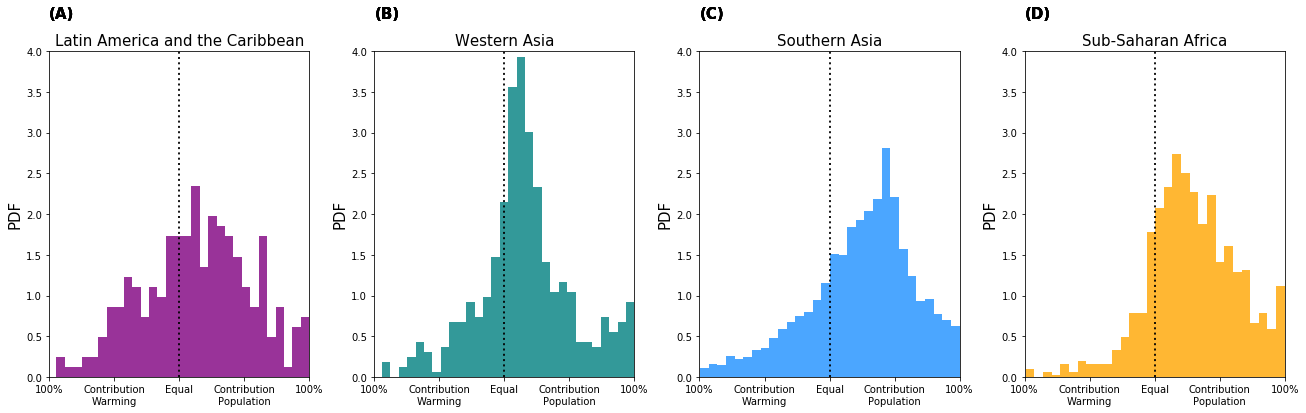

In [5]:
#### Fig 3 Plot - 4 Panel CPT 2020.04.08 / Feb 2021 WBGT28 day

# Chunks in a list & colors
df_list = [chunk1 , chunk2 , chunk3 , chunk4]
color_list = ['purple', 'teal', 'dodgerblue', 'orange']
loc_list = [loc1, loc2, loc3, loc4]

# Size
fig, axs = plt.subplots(1, 4, figsize = (24, 6), sharex=False, sharey = False)
axs = axs.ravel()
fig.subplots_adjust(wspace= 0.25, hspace = 0.35)
fig = plt.gcf()

# Plot args
kwargs = {'lw': 3, 'alpha' : 0.9, 'linestyle' : '-'} # ked line kwargs

for i, df in enumerate(zip(df_list, color_list)):
    
    xlim = [0,1]
    ylim = [0,4]
    ticks = [0, .25, .5, .75, 1]
    #labels = [str(100), 50, 0, 50, str(100)]#[100, 80, 60, 40, 20, 0, 20, 40, 60, 80, 100]
    labels = ['100%','Contribution\nWarming', 'Equal', 'Contribution\nPopulation', '100%']
    
    # Git data for hist  
    data = df[0]['coef_attrib_norm'] 
    data = np.where(data < -100, -100, data) # set all values with >100% warming to 0 
    data = np.where(data > 100, 100, data) # set all values with >100% pop to 0
    axs[i].hist(data, density = True, color = df[1], alpha = 0.8, bins = 30) 
    x = axs[i].hist(data, density = True, color = df[1], alpha = 0, bins = 30)[1]
    y = axs[i].hist(data, density = True, color = df[1], alpha = 0, bins = 30)[0]
    y = np.insert(y, 0, y[0])

    # Poly fit plot
#     x = x[:, np.newaxis]
#     y = y[:, np.newaxis]
#     polynomial_features= PolynomialFeatures(degree=4)
#     x_poly = polynomial_features.fit_transform(x)
#     model = LinearRegression()
#     model.fit(x_poly, y)
#     y_poly_pred = model.predict(x_poly)
#     sort_axis = operator.itemgetter(0)
#     sorted_zip = sorted(zip(x,y_poly_pred), key=sort_axis)
#     x, y_poly_pred = zip(*sorted_zip)
    #axs[i].plot(x, y_poly_pred, alpha = 1, linewidth=3, color = color_list[i], linestyle = '-.')

    # V line 
    axs[i].vlines(x = 0.5, ymin = 0, ymax = 5, lw=2, linestyles = ':', 
                  alpha = 0.9, color = 'black')

    #sns.kdeplot(data, color = df[1], ax = axs[i], **kwargs, legend = False) # kernel
    axs[i].set_title(loc_list[i], fontsize = 15) 
    axs[i].set_xlim(xlim)
    axs[i].set_ylim(ylim)
    axs[i].set_ylabel('PDF', fontsize = 15)
    
    #axs[i].set_xlabel('% Warming                 % Population', fontsize = 15)
    axs[i].set_xticks(ticks);
    axs[i].set_xticklabels(labels)
    
    # add panel labels
    axs[0].text(0.00, 1.1, '(A)', transform=axs[0].transAxes, size=15, fontweight='bold')
    axs[0].text(1.25, 1.1, '(B)', transform=axs[0].transAxes, size=15, fontweight='bold')
    axs[0].text(2.5, 1.1, '(C)', transform=axs[0].transAxes, size=15, fontweight='bold')
    axs[0].text(3.75, 1.1, '(D)', transform=axs[0].transAxes, size=15, fontweight='bold')
    
### color bar on far left plot
kwargs = {'anchor' : (-0.5, 0.5), 'fraction' : .01, 'shrink' : 2}
fig.subplots_adjust(right=0.84)

plt.savefig(FN_OUT, dpi = 300, bbox_inches='tight')

# More panels

In [6]:
# #### Fig 3 Plot

# # Chunks in a list & colors
# df_list = [plotdata1 , plotdata2 , plotdata3 , plotdata4, plotdata1 , plotdata2 , plotdata3 , plotdata4]
# color_list = ['purple', 'teal', 'dodgerblue', 'orange', 'purple', 'teal', 'dodgerblue', 'orange']
# loc_list = [loc1, loc2, loc3, loc4, loc1, loc2, loc3, loc4]

# # Size
# fig, axs = plt.subplots(2, 4, figsize = (24, 12), sharex=False, sharey = False)
# axs = axs.ravel()
# fig.subplots_adjust(wspace= 0.25, hspace = 0.35)
# fig = plt.gcf()

# # Plot args
# kwargs = {'lw': 3, 'alpha' : 0.9, 'linestyle' : '-'} # ked line kwargs

# for i, df in enumerate(zip(df_list, color_list)):
    
#     # First row
#     if i < 4:
#         xlim = [0,1]
#         ylim = [0,4]
#         ticks = [0, .25, .5, .75, 1]
#         #labels = [str(100), 50, 0, 50, str(100)]#[100, 80, 60, 40, 20, 0, 20, 40, 60, 80, 100]
#         labels = ['100%','Contribution\nWarming', 'Equal', 'Contribution\nPopulation', '100%']
        
#         # Git data for hist and poly fit 
#         data = df[0]['coef_attrib_norm'] 
#         axs[i].hist(data, density = True, color = df[1], alpha = 0.15, bins = 30) 
#         x = axs[i].hist(data, density = True, color = df[1], alpha = 0, bins = 30)[1]
#         y = axs[i].hist(data, density = True, color = df[1], alpha = 0, bins = 30)[0]
#         y = np.insert(y, 0, y[0])
        
#         # Poly fit plot
#         x = x[:, np.newaxis]
#         y = y[:, np.newaxis]
#         polynomial_features= PolynomialFeatures(degree=4)
#         x_poly = polynomial_features.fit_transform(x)
#         model = LinearRegression()
#         model.fit(x_poly, y)
#         y_poly_pred = model.predict(x_poly)
#         sort_axis = operator.itemgetter(0)
#         sorted_zip = sorted(zip(x,y_poly_pred), key=sort_axis)
#         x, y_poly_pred = zip(*sorted_zip)
#         axs[i].plot(x, y_poly_pred, alpha = 0.9, linewidth=3, color = color_list[i])
        
#         # V line 
#         axs[i].vlines(x = 0.5, ymin = 0, ymax = 5, lw=2, linestyles = ':', 
#                       alpha = 0.5, color = 'black')
        
#         #sns.kdeplot(data, color = df[1], ax = axs[i], **kwargs, legend = False) # kernel
#         axs[i].set_title(loc_list[i], fontsize = 15) 
#         axs[i].set_xlim(xlim)
#         axs[i].set_ylim(ylim)
#         axs[i].set_ylabel('PDF', fontsize = 15)
#         #axs[i].set_xlabel('% Warming                 % Population', fontsize = 15)
#         axs[i].set_xticks(ticks);
#         axs[i].set_xticklabels(labels)
    
#     # Second row
#     if i >= 4:
#         lim = 8
        
#         # Make Data
#         X = np.log10(df[0]['coef_pop'])
#         Y = np.log10(df[0]['coef_heat'])
#         C = np.log10(df[0]['P2016']) 

#         # plots
#         im  = axs[i].scatter(X, Y, alpha = 0.4, marker = 'h', c = C, cmap = 'rainbow')

#         # Make one-to-one-line
#         axs[i].plot([0, lim], [0, lim], ':', lw=3, alpha = 0.7, color = 'black')
#         axs[i].set_title(loc_list[i], fontsize = 15)
        
#         if i == 4:
#             cmap = axs[i].scatter(X, Y, alpha = 0.4, marker = 'h', c = C, cmap = 'rainbow')

#         #fig.colorbar(ax = axs[i],  mappable = cmap) color Bar all ploots

#         # Set limits
#         axs[i].set_xlim([-0.5, lim])
#         axs[i].set_ylim([-0.5, lim])
        
#         axs[i].set_ylabel('Increase from Warming [log10]', fontsize = 15)
#         axs[i].set_xlabel('Increase from Population [log10]', fontsize = 15)

#     # add panel labels
#     axs[0].text(0.00, 1.1, '(a)', transform=axs[0].transAxes, size=15 )
#     axs[0].text(1.25, 1.1, '(b)', transform=axs[0].transAxes, size=15 )
#     axs[0].text(2.5, 1.1, '(c)', transform=axs[0].transAxes, size=15 )
#     axs[0].text(3.75, 1.1, '(d)', transform=axs[0].transAxes, size=15 )
#     axs[0].text(0.00, -.24, '(e)', transform=axs[0].transAxes, size=15 )
#     axs[0].text(1.25, -.24, '(f)', transform=axs[0].transAxes, size=15 )
#     axs[0].text(2.5, -.24, '(g)', transform=axs[0].transAxes, size=15 )
#     axs[0].text(3.75, -.24, '(h)', transform=axs[0].transAxes, size=15 )

    
# ### color bar on far left plot
# kwargs = {'anchor' : (-0.5, 0.5), 'fraction' : .01, 'shrink' : 2}
# fig.subplots_adjust(right=0.84)
# cbar_ax = fig.add_axes([0.85, 0.12, 0.01, 0.33])
# fig.colorbar(im, cax=cbar_ax, **kwargs)

# Set the ticks and ticklabels for all axes
#plt.setp(axs, xticks=ticks, xticklabels=labels);

## Labels 
# plt.xlabel('Coef of Attribtuion (Right is people, left heat)', fontsize = 15, labelpad = 10)
# plt.ylabel('PDF', fontsize = 15)
# fig.title('Dist of PeopleDays Attribution Coef, 1983 - 2016', fontsize = 15)
#plt.savefig(FIG_OUT+FNOUT, dpi = 300, bbox_inches='tight')

# Try poly fit

In [7]:
# data = plotdata1
# title = loc1
# Y = plt.hist(data['coef_attrib'], bins = 30)[0]
# X = plt.hist(data['coef_attrib'], bins = 30)[1]
# Y = np.insert(Y, 0, Y[0])

In [8]:
# import operator

# import numpy as np
# import matplotlib.pyplot as plt

# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import mean_squared_error, r2_score
# from sklearn.preprocessing import PolynomialFeatures

# np.random.seed(0)
# x = X
# y = Y

# # transforming the data to include another axis
# x = x[:, np.newaxis]
# y = y[:, np.newaxis]

# polynomial_features= PolynomialFeatures(degree=4)
# x_poly = polynomial_features.fit_transform(x)

# model = LinearRegression()
# model.fit(x_poly, y)
# y_poly_pred = model.predict(x_poly)

# rmse = np.sqrt(mean_squared_error(y,y_poly_pred))
# r2 = r2_score(y,y_poly_pred)
# print(rmse)
# print(r2)

# plt.hist(data['coef_attrib'], bins = 30, alpha = .2)
# # sort the values of x before line plot
# sort_axis = operator.itemgetter(0)
# sorted_zip = sorted(zip(x,y_poly_pred), key=sort_axis)
# x, y_poly_pred = zip(*sorted_zip)
# plt.plot(x, y_poly_pred, color='m')
# plt.title(title+' 4th order poly R2='+str(round(r2,2)))
# plt.show()